In [6]:
import pandas as pd
from ortools.sat.python import cp_model
import collections
from datetime import timedelta
import datetime
from pandas import ExcelWriter
from pandas import ExcelFile
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

%matplotlib inline

### 1. Data preparation

In [10]:
# Import Data
df = pd.read_excel('Toy Job Shop problem v2.xlsx', sheet_name='Data')
# Set start date
initial_date = '2019-10-01'

# Create initialisation date 2019-10-01
df = df.assign(Initialisation_Date = pd.to_datetime(initial_date))

# Define the start of the transition phase
df['Transition_Date_Start'] = np.nan

# For Organisations 1 - 5 transition start date is latest of last
# of Org 1 - 5 to finish task 2 + 5 day wait period or 6-7 finish task 4
mask = df['Organisation'].isin(['Org {}'.format(i) for i in range(0,6)])
df['min_completion_date'] = df['Task 2 Completion date'] + pd.to_timedelta(df['Task 3 length'], unit='D') + pd.to_timedelta(df['Task 4 length'], unit='D') + timedelta(days=5)
t = max(df.loc[mask,'Task 2 Completion date']) + timedelta(days=5)
s = max(df.loc[-mask,'min_completion_date'])
df.loc[mask, 'Transition_Date_Start'] = max(t, s).date()
df.loc[-mask, 'Transition_Date_Start'] = max(df.loc[-mask,'Task 2 Completion date']).date()

# Organisation 5 can only start Task 3 when either Organisation 2 or 4
# is at least 7 days into their Transition Phase.
org_2_task3_startdate = df.loc[1,"Transition_Date_Start"]
# Define Org_4 Transition phase start
org_4_task3_startdate = df.loc[3,"Transition_Date_Start"]
# Define Org_5 start date for Task 3
org_5_startdate = min(org_2_task3_startdate,org_4_task3_startdate) + timedelta(days=7)
# Insert Org_5 start date into dataframe
df.loc[4,"Transition_Date_Start"] = pd.to_datetime(org_5_startdate).date()
df['Transition_Date_Start'] = pd.to_datetime(df['Transition_Date_Start'])

# Compute waiting days between task2 end date and transition start date 
wait_days = df['Transition_Date_Start'] - df['Task 2 Completion date']
pause_length = [l.days for l in wait_days]
df['Pause_length'] = pause_length

# Create Task_1_length column (int)
df['Task_1_length'] = ((df['Task 1 completion date'] - df['Initialisation_Date']) / np.timedelta64(1,'D')).astype(int)

# Creating Task_2_length colum (int)
df['Task_2_length'] = ((df['Task 2 Completion date'] - df['Task 1 completion date']) / np.timedelta64(1,'D')).astype(int)

df


,Organisation,Task 1 completion date,Task 2 Completion date,Task 3 length,Task 4 length,Initialisation_Date,Transition_Date_Start,min_completion_date,Pause_length,Task_1_length,Task_2_length
0,Org 1,2019-10-09,2019-10-16,15,5,2019-10-01,2019-11-12,2019-11-10,27,8,7
1,Org 2,2019-10-10,2019-10-17,15,10,2019-10-01,2019-11-12,2019-11-16,26,9,7
2,Org 3,2019-10-15,2019-10-18,15,10,2019-10-01,2019-11-12,2019-11-17,25,14,3
3,Org 4,2019-10-12,2019-10-16,20,5,2019-10-01,2019-11-12,2019-11-15,27,11,4
4,Org 5,2019-10-13,2019-10-20,25,5,2019-10-01,2019-11-19,2019-11-24,30,12,7
5,Org 6,2019-10-08,2019-10-18,13,7,2019-10-01,2019-10-23,2019-11-12,5,7,10
6,Org 7,2019-10-14,2019-10-23,8,5,2019-10-01,2019-10-23,2019-11-10,0,13,9


### 2. Model build

In [11]:
# remove unneeded columns
df = df[['Organisation','Task_1_length', 'Task_2_length','Pause_length','Task 3 length','Task 4 length']]

jobs_data = []
for j in range (1, len(df.columns)):
    ls = []
    for i in range (0,len(df.index)):
        task = (i+1, df.iloc[i,j])
        ls.append(task)
    jobs_data.append(ls)
    
org_count = 1 + max(task[0] for job in jobs_data for task in job)
all_organisations = range(org_count)

# Named tuple to store information about created variables.
task_type = collections.namedtuple('task_type', 'start end interval')
# Named tuple to manipulate solution information.
assigned_task_type = collections.namedtuple('assigned_task_type',
                                            'start job index duration')

# Create job intervals and add to the corresponding machine lists.
all_tasks = {}
org_to_intervals = collections.defaultdict(list)

# Computes horizon dynamically as the sum of all durations.
horizon = sum(task[1] for job in jobs_data for task in job)

# Define model
model = cp_model.CpModel()

for job_id, job in enumerate(jobs_data):
        for task_id, task in enumerate(job):
            organisation = task[0]
            duration = task[1]
            suffix = '_%i_%i' % (job_id, task_id)
            start_var = model.NewIntVar(0, int(horizon), 'start' + suffix)
            end_var = model.NewIntVar(0, int(horizon), 'end' + suffix)
            interval_var = model.NewIntervalVar(start_var, duration, end_var,
                                                'interval' + suffix)
            all_tasks[job_id, task_id] = task_type(
                start=start_var, end=end_var, interval=interval_var)
            org_to_intervals[organisation].append(interval_var)

# Create and add disjunctive constraints.
for organisation in all_organisations:
    model.AddNoOverlap(org_to_intervals[organisation])

# Makespan objective.
obj_var = model.NewIntVar(0, int(horizon), 'makespan')
model.AddMaxEquality(obj_var, [
    all_tasks[job_id, len(job) - 1].end
    for job_id, job in enumerate(jobs_data)])
model.Minimize(obj_var)

# # Declare the solver
# Solve model.
solver = cp_model.CpSolver()
status = solver.Solve(model)

# # Display the results
# Create one list of assigned tasks per machine.
assigned_jobs = collections.defaultdict(list)
for job_id, job in enumerate(jobs_data):
    for task_id, task in enumerate(job):
        organisation = task[0]
        assigned_jobs[organisation].append(
            assigned_task_type(
                start=solver.Value(all_tasks[job_id, task_id].start),
                job=job_id,
                index=task_id,
                duration=task[1]))

# Create per organisation output lines in date format
output_date = ''
for organisation in all_organisations:
    # Sort by starting time.
    assigned_jobs[organisation].sort()
    sol_line_tasks = 'Organisation ' + str(organisation) + ': '
    sol_line = '           '

    for assigned_task in assigned_jobs[organisation]:
        name = 'job_%i_%i' % (assigned_task.job, assigned_task.index)
        # Add spaces to output to align columns.
        sol_line_tasks += '%-10s' % name
        
        start_date = '2019/10/01'
        Initialisation_Date = datetime.datetime.strptime(start_date, '%Y/%m/%d')
        
        start = int(assigned_task.start)
        duration = int(assigned_task.duration)
        start_date = Initialisation_Date + timedelta(start)
        start_duration_date = Initialisation_Date + timedelta(start) + timedelta(duration)
        start_date_str = str(start_date.date())
        start_duration_date_str = str(start_duration_date.date())
        sol_tmp = '[%s,%s]' % (start_date_str, start_duration_date_str)
        # Add spaces to output to align columns.
        sol_line += '%-10s' % sol_tmp
        
    sol_line += '\n'
    sol_line_tasks += '\n'
    output_date += sol_line_tasks
    output_date += sol_line

# Finally print the solution found in datetime format.
print('Optimal Schedule Length: %i' % solver.ObjectiveValue())
print(output_date)

Optimal Schedule Length: 35
Organisation 0: 
           
Organisation 1: job_0_0   job_1_0   job_2_0   job_3_0   job_4_0   
           [2019-10-01,2019-10-09][2019-10-09,2019-10-16][2019-10-16,2019-11-12][2019-11-12,2019-11-27][2019-11-27,2019-12-02]
Organisation 2: job_0_1   job_1_1   job_2_1   job_3_1   job_4_1   
           [2019-10-01,2019-10-10][2019-10-10,2019-10-17][2019-10-17,2019-11-12][2019-11-12,2019-11-27][2019-11-27,2019-12-07]
Organisation 3: job_0_2   job_1_2   job_2_2   job_3_2   job_4_2   
           [2019-10-01,2019-10-15][2019-10-15,2019-10-18][2019-10-18,2019-11-12][2019-11-12,2019-11-27][2019-11-27,2019-12-07]
Organisation 4: job_0_3   job_1_3   job_2_3   job_3_3   job_4_3   
           [2019-10-01,2019-10-12][2019-10-12,2019-10-16][2019-10-16,2019-11-12][2019-11-12,2019-12-02][2019-12-02,2019-12-07]
Organisation 5: job_0_4   job_1_4   job_2_4   job_3_4   job_4_4   
           [2019-10-01,2019-10-13][2019-10-13,2019-10-20][2019-10-20,2019-11-19][2019-11-19,2019-12-

### 3. Visualisation

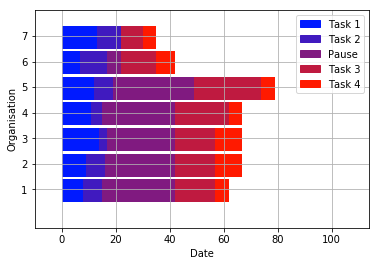

In [12]:
# Visualisation
#Declaring variables which will store the solver data to be plotted later
StartTimes = []
Durations = []
EndTimes = []
OrganisationName = []
job = []
task = []
loopnumber = []
x=0
Org = 0
OrgNumber = []

#loop over all organisationa and jobs/tasks to fill arrays with solver data
for organisation in all_organisations:
    for assigned_task in assigned_jobs[organisation]:
        start = assigned_task.start
        duration = assigned_task.duration
        StartTimes.append(start)
        Durations.append(duration)
        OrganisationName.append(organisation)
        EndTimes.append(start+duration)
        job.append(assigned_task.job)
        task.append(assigned_task.index)
        OrgNumber.append(Org)
        loopnumber.append(x)
        x=x+1
    Org = Org + 1        

#
Distinctjob = np.unique(job)

#Colour is based on a scale of 0-1, so I use their job number to define their colour and give each job a seperate colour
No_jobs = max(job)
Colour = np.divide(job,No_jobs)

# Declaring a figure "gnt" 
fig, gnt = plt.subplots() 

# Setting Y-axis limits 
gnt.set_ylim(0, 10*max(OrgNumber)+15) 
# Setting X-axis limits 
gnt.set_xlim(min(StartTimes)-10, max(EndTimes)+35) 
# Setting labels for x-axis and y-axis 
gnt.set_xlabel('Date') 
gnt.set_ylabel('Organisation') 

#Finding distinct organisations and numbering so that I can plot their name on the Y-axis
DistinctOrgName = np.unique(OrganisationName)
DistinctOrgNumber = np.unique(OrgNumber)
YTicks = DistinctOrgNumber*10+5
# Setting ticks on y-axis 
gnt.set_yticks(YTicks)
# Labelling tickes of y-axis 
gnt.set_yticklabels(DistinctOrgName) 

# Setting graph attribute 
gnt.grid(True) 

#Looping over all tasks numbers to create their bar on the chart
for y in loopnumber:
        gnt.broken_barh([(StartTimes[y], Durations[y])], (10*OrgNumber[y], 9),facecolors =(Colour[y],0.1,1-Colour[y]))
        y=y+1

#Looping over all distinct jobs to label them with their colour in the legend
patchList = []
tasks = [1, 2, '_', 3, 4]
for task, j in zip(tasks, Distinctjob):
    if j == 2:
        data_key = mpatches.Patch(color=(j/No_jobs,0.1,1-j/No_jobs), label='Pause')
        patchList.append(data_key)
        continue
    data_key = mpatches.Patch(color=(j/No_jobs,0.1,1-j/No_jobs), label='Task ' + str(task))
    patchList.append(data_key)
plt.legend(handles=patchList);